## The stated goal is to predict daily demand with time, temperature and holiday information 
using various scikit-learn methods. 

For this kind of problem we need a target variable and a whole lot of normalized predictor variables.

## This runs in seconds on my laptop.


In [1]:
import pandas as pd

# read data fetched in the previous step
daily_demand_df = pd.read_csv("dataframes/daily_demand_df.csv.gz", compression="infer", parse_dates=["opday"])
weather_df      = pd.read_csv("dataframes/weather_df.csv.gz", compression="infer", parse_dates=["DATE"])
holiday_df      = pd.read_csv("dataframes/holiday_df.csv.gz", compression="infer", parse_dates=["date"]).set_index("date")


## Create one-hot weekday list
using the target list's date field

In [2]:
dayofweek_onehot = daily_demand_df[['opday']]
dayofweek_onehot['is'] = dayofweek_onehot.opday.dt.day_name()
dayofweek_onehot = pd.get_dummies(dayofweek_onehot.set_index('opday'))
dayofweek_onehot

,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
opday,,,,,,,
2015-10-01,0,0,0,0,1,0,0
2015-10-02,1,0,0,0,0,0,0
2015-10-03,0,0,1,0,0,0,0
2015-10-04,0,0,0,1,0,0,0
2015-10-05,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2019-12-28,0,0,1,0,0,0,0
2019-12-29,0,0,0,1,0,0,0
2019-12-30,0,1,0,0,0,0,0


In [3]:
holiday_df.dtypes

holiday    object
dtype: object

## Create one-hot holiday list

In [4]:
holiday_onehot = pd.get_dummies(holiday_df)
holiday_onehot['is_holiday'] = holiday_onehot.sum(axis=1)
holiday_onehot

,holiday_Christmas Day,holiday_Christmas Eve,holiday_Day After Thanksgiving,holiday_Independence Day,holiday_Labor Day,holiday_Memorial Day,holiday_New Year's Day,holiday_Thanksgiving,is_holiday
date,,,,,,,,,
2015-01-01,0,0,0,0,0,0,1,0,1
2015-05-25,0,0,0,0,0,1,0,0,1
2015-07-03,0,0,0,1,0,0,0,0,1
2015-07-04,0,0,0,1,0,0,0,0,1
2015-09-07,0,0,0,0,1,0,0,0,1
2015-11-26,0,0,0,0,0,0,0,1,1
2015-11-27,0,0,1,0,0,0,0,0,1
2015-12-24,0,1,0,0,0,0,0,0,1
2015-12-25,1,0,0,0,0,0,0,0,1


## Get the weather DF into a single row per day with all predictor attributes

In [5]:
for station in weather_df.STATION.unique():
    print (station)

CO_DENVER_INTL_AP
IA_SIOUX_CITY_GATEWAY_AP
NM_CLAYTON_MUNI_AIR_PK
IA_WATERLOO_MUNI_AP
TX_ABILENE_RGNL_AP
AR_HOT_SPRINGS_ASOS
SD_MITCHELL_MUNI_AP
NE_NORTH_PLATTE_RGNL_AP
MN_ST_CLOUD_RGNL_AP
KS_DODGE_CITY
TX_DALHART_MUNI_AP
CO_BURLINGTON_CARSON_AP
MT_BAKER_MUNI_AP
AR_LITTLE_ROCK_AP_ADAMS_FLD
NE_HAYES_CENTER_1NW
MN_ST_PAUL_DOWNTOWN_AP
MN_MPLS_FLYING_CLOUD_AP
OK_LAWTON_MUNI_AP
NE_IMPERIAL_MUNI_AP
NE_CHADRON_MUNI_AP
TX_WICHITA_FALLS_MUNI_AP
SD_MOBRIDGE_MUNI_AP
CO_ALAMOSA_SAN_LUIS_AP
NE_NORFOLK_KARL_STEFAN_AP
CO_COLORADO_SPRINGS_MUNI_AP
CO_PUEBLO_MEM_AP
SD_ABERDEEN
WY_CHEYENNE
AR_FT_SMITH_RGNL_AP
WY_TORRINGTON_MUNI_AP
NM_LAS_VEGAS_MUNI_AP
NE_OMAHA_EPPLEY_AIRFIELD
KS_CONCORDIA_MUNI_AP
MO_SPRINGFIELD
IA_MARSHALLTOWN_MUNI_AP
KS_WICHITA
TX_WACO_RGNL_AP
NE_BROKEN_BOW_MUNI_AP
TX_FT_WORTH_ALLIANCE_AP
ND_FARGO_HECTOR_INTL_AP
TX_SAN_ANGELO
TX_CHILDRESS_MUNI_AP
NE_VALENTINE_MILLER_FLD
ND_JAMESTOWN_MUNI_AP
LA_SHREVEPORT
NE_HASTINGS_MUNI_AP
MO_KANSAS_CITY_INTL_AP
IA_ESTHERVILLE_MUNI_AP
TX_MIDLAND_ODESSA

## The original analysis summed the HDD and CDD columns over all weather stations

In [6]:
np_sum_cdd = weather_df.pivot(index=['DATE'], columns='STATION', values=['CDD']).sum(axis=1)
sum_cdd_df = pd.DataFrame(np_sum_cdd, columns = ['SUM_CDD'])
np_sum_hdd = weather_df.pivot(index=['DATE'], columns='STATION', values=['HDD']).sum(axis=1)
sum_hdd_df = pd.DataFrame(np_sum_hdd, columns = ['SUM_HDD'])
sum_hdd_df

,SUM_HDD
DATE,
2015-01-01,4037.13
2015-01-02,3717.99
2015-01-03,3658.23
2015-01-04,4887.54
2015-01-05,4815.54
...,...
2019-12-29,2870.91
2019-12-30,3346.92
2019-12-31,3446.82


In [7]:
# pivot out all weather values by day; append station name to column name:

weather_pivot = weather_df.pivot(index=['DATE'], columns='STATION', values=['TMIN', 'TMAX', 'TAVG','CDD','HDD'])
# try removing all but TAVG
#weather_pivot = weather_df.pivot(index=['DATE'], columns='STATION', values=['TAVG'])

weather_pivot.columns = ['_'.join(col).strip() for col in weather_pivot.columns.values]
# merge in CDD and HDD sums

# or maybe not: 
#weather_pivot = weather_pivot.merge(sum_cdd_df, on='DATE').merge(sum_hdd_df, on='DATE')
weather_pivot


,TMIN_AR_FAYETTEVILLE_DRAKE_FLD,TMIN_AR_FT_SMITH_RGNL_AP,TMIN_AR_HARRISON_BOONE_CO_AP,TMIN_AR_HOT_SPRINGS_ASOS,TMIN_AR_LITTLE_ROCK,TMIN_AR_LITTLE_ROCK_AP_ADAMS_FLD,TMIN_AR_MOUNTAIN_HOME_BAXTER_AP,TMIN_AR_MOUNT_IDA_ASOS,TMIN_AR_TEXARKANA_WEBB_FLD,TMIN_CO_ALAMOSA_SAN_LUIS_AP,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-01,-1.6,-0.5,-0.5,1.7,1.1,1.7,-1.0,1.7,1.1,-22.7,...,31.74,30.12,32.37,43.44,42.72,38.94,29.58,38.76,54.42,56.31
2015-01-02,0.6,2.2,0.6,2.2,1.1,2.8,1.1,2.2,2.2,-22.7,...,27.96,26.34,28.50,37.68,35.88,32.82,26.52,33.18,40.02,45.87
2015-01-03,3.3,4.4,2.2,5.0,5.6,6.7,2.2,3.9,2.8,-22.1,...,22.92,21.84,18.51,34.44,29.94,25.08,22.38,27.06,41.28,54.42
2015-01-04,-9.3,-6.0,-8.8,-2.7,-3.8,-3.2,-7.7,-3.8,-2.1,-21.6,...,26.52,26.88,32.37,37.68,30.48,24.72,25.62,33.18,54.78,69.00
2015-01-05,-9.9,-7.1,-11.6,-6.0,-7.1,-5.5,-11.0,-8.2,-5.5,-17.7,...,33.18,31.02,33.90,32.28,28.50,29.76,33.00,36.24,34.08,29.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29,3.3,4.4,3.3,5.0,4.4,5.6,4.4,4.4,5.0,-27.7,...,14.82,13.02,18.96,27.24,21.30,17.70,13.02,20.94,47.58,39.84
2019-12-30,0.6,1.7,0.0,1.7,2.2,0.6,1.7,1.1,1.7,-32.1,...,20.22,19.32,21.48,31.56,27.96,25.62,22.74,24.54,47.40,43.35
2019-12-31,-3.2,-2.1,-1.0,0.0,1.1,-0.5,-0.5,-1.6,-0.5,-32.1,...,20.76,20.40,20.04,28.32,25.26,25.44,22.92,25.26,40.56,40.92


## Create a target dataframe with the target variable and all the potential predictors

In [8]:
# merge daily_demand_f and dayofweek_onehot

target_df = daily_demand_df.merge(dayofweek_onehot, on='opday')
target_df

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,2015-10-01,502184.942993,0,0,0,0,1,0,0
1,2015-10-02,612695.032412,1,0,0,0,0,0,0
2,2015-10-03,566229.834662,0,0,1,0,0,0,0
3,2015-10-04,552166.723416,0,0,0,1,0,0,0
4,2015-10-05,596751.461994,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1549,2019-12-28,648146.557000,0,0,1,0,0,0,0
1550,2019-12-29,661993.471000,0,0,0,1,0,0,0
1551,2019-12-30,752393.427000,0,1,0,0,0,0,0
1552,2019-12-31,746139.564000,0,0,0,0,0,1,0


In [9]:
# append holiday_onehot

target_df = target_df.merge(holiday_onehot, how = 'left', left_on='opday', right_on = 'date').fillna(0, downcast="infer")
target_df

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,holiday_Christmas Eve,holiday_Day After Thanksgiving,holiday_Independence Day,holiday_Labor Day,holiday_Memorial Day,holiday_New Year's Day,holiday_Thanksgiving,is_holiday
0,2015-10-01,502184.942993,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2015-10-02,612695.032412,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-10-03,566229.834662,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-10-04,552166.723416,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-10-05,596751.461994,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,2019-12-28,648146.557000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1550,2019-12-29,661993.471000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1551,2019-12-30,752393.427000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1552,2019-12-31,746139.564000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [10]:
# append weather_pivot

target_df = target_df.merge(weather_pivot, left_on='opday', right_on = 'DATE')
target_df

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP
0,2015-10-01,502184.942993,0,0,0,0,1,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.40,0.96
1,2015-10-02,612695.032412,1,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.32,10.95
2,2015-10-03,566229.834662,0,0,1,0,0,0,0,0,...,0.00,0.00,1.05,5.28,0.00,0.00,0.00,3.30,18.24,16.98
3,2015-10-04,552166.723416,0,0,0,1,0,0,0,0,...,0.00,0.00,0.00,8.34,0.00,0.00,0.00,1.14,18.96,15.00
4,2015-10-05,596751.461994,0,1,0,0,0,0,0,0,...,0.00,0.00,0.00,7.44,1.14,0.00,0.00,1.14,12.30,7.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,2019-12-28,648146.557000,0,0,1,0,0,0,0,0,...,2.94,1.32,6.99,15.18,7.26,3.12,2.58,6.36,41.64,37.77
1550,2019-12-29,661993.471000,0,0,0,1,0,0,0,0,...,14.82,13.02,18.96,27.24,21.30,17.70,13.02,20.94,47.58,39.84
1551,2019-12-30,752393.427000,0,1,0,0,0,0,0,0,...,20.22,19.32,21.48,31.56,27.96,25.62,22.74,24.54,47.40,43.35
1552,2019-12-31,746139.564000,0,0,0,0,0,1,0,0,...,20.76,20.40,20.04,28.32,25.26,25.44,22.92,25.26,40.56,40.92


In [11]:
# one station doesn't have data for one day; just exclude that one row. 
target_df.dropna(inplace=True)

In [12]:
# there are some very small values of sum_spp_load.  We know 
# that the footprint demand is something like 25,000 MWh at a minimun, so summed over 24 
# hours should be in the neighborhood of 600,000 MWh.  If the sum isn't nearly that, 
# it's bad data. 
target_df.drop(target_df[target_df['sum_spp_load'] < 540000].index, inplace=True)
target_df[target_df['sum_spp_load'] < 540000]

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP


## Save out the completed target dataframe

In [13]:

# save the complete target dataframe
target_df.to_csv("dataframes/target_df.csv.gz", compression="infer", index=False)
#target_df.to_pickle("dataframes/target_df.pickle.gz", compression="infer")


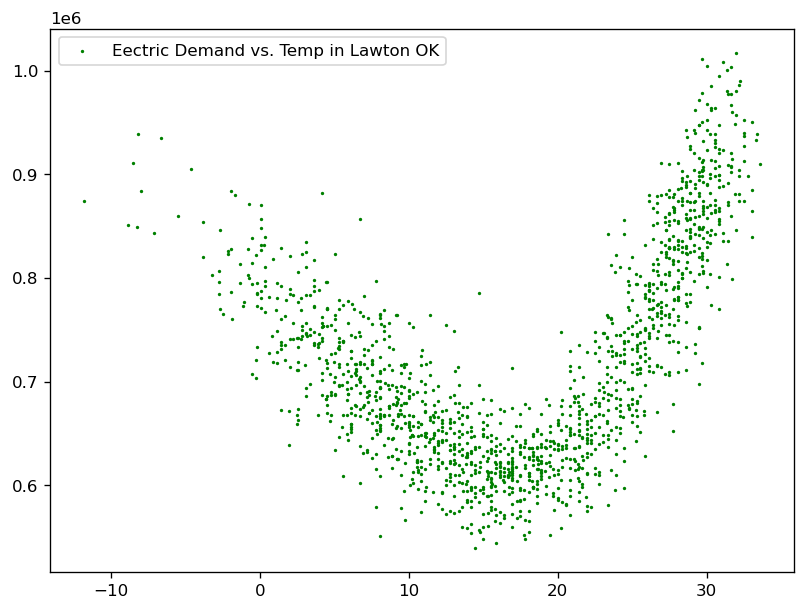

In [14]:
# just for fun, plot TAVG_KS_ANTHONY against SPP load: 
# scatter plot true vs. predicted values 
import pylab as pl
%matplotlib inline
from pylab import *

pl.figure(figsize=(8, 6), dpi=120)
#pl.scatter(target_df['TAVG_KS_ANTHONY'], target_df['sum_spp_load'],  c="y", label='Eectric Demand vs. Temp in Anthony KS', s=1)
#pl.scatter(target_df['TAVG_NE_LINCOLN_MUNI_AP'], target_df['sum_spp_load'],  c="m", label='Eectric Demand vs. Temp in Lincoln NE', s=1)
pl.scatter(target_df['TAVG_OK_LAWTON_MUNI_AP'], target_df['sum_spp_load'],  c="g", label='Eectric Demand vs. Temp in Lawton OK', s=1)

pl.legend()
pl.show()


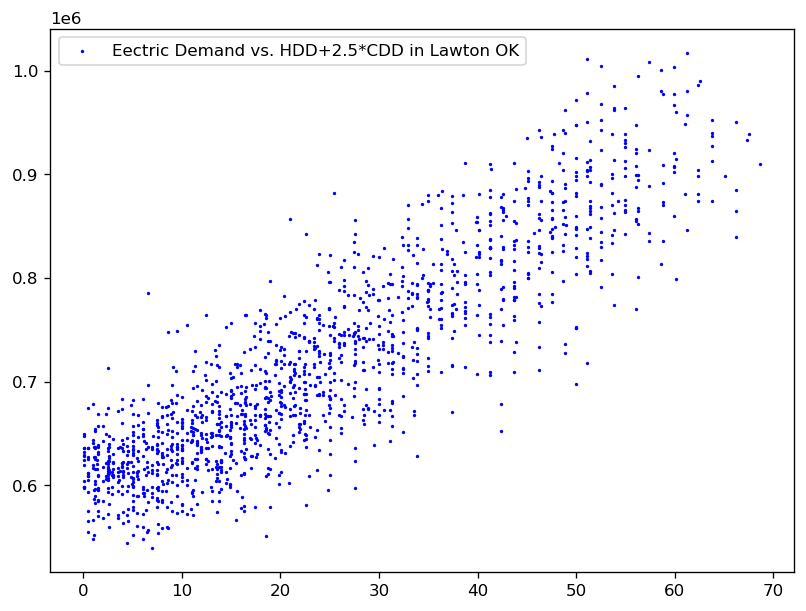

In [15]:
# just for fun, plot TAVG_KS_ANTHONY against SPP load: 
# scatter plot true vs. predicted values 
import pylab as pl
%matplotlib inline
from pylab import *

pl.figure(figsize=(8, 6), dpi=120)
pl.scatter(target_df['HDD_OK_LAWTON_MUNI_AP']  + target_df['CDD_OK_LAWTON_MUNI_AP'] * 2.5, target_df['sum_spp_load'],
           c="b", label='Eectric Demand vs. HDD+2.5*CDD in Lawton OK', s=1)
pl.legend()
pl.show()
